In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
%cd /drive/MyDrive/'Speaker-Diarization-ATML2021'/pretrain
%ls

/drive/MyDrive/Speaker-Diarization-ATML2021
all_transcripts.json  data_generator.py   layers.py       __pycache__/
augment.py            helper_funcs.py     model.py        voxconverse_dev@
ckpt@                 icsimeetingcorpus@  pretrain.ipynb


In [ ]:
import tensorflow as tf
import tensorflow.keras as K
import copy
import json
import os

from data_generator import *
from helper_funcs import *
from layers import *
from model import *
from augment import *

In [ ]:
# configurations
n_mfcc = 13
minimum_speaker_len = 2
 
M = 16
batch_size = 128
train_stpe = 20
val_stpe = 5

In [ ]:
icsi_audio_dir = "icsimeetingcorpus/Signals"
icsi_segments_dir = "icsimeetingcorpus/ICSIplus/Segments"
cache_dir = "/content/sample_data"

In [ ]:
if os.path.isfile('all_transcripts.json'):
    with open('all_transcripts.json', 'r') as json_file:
        all_transcripts = json.load(json_file)
else:
    all_transcripts = gather_transcripts(icsi_segments_dir)
    with open('all_transcripts.json', 'w') as json_file:
        json.dump(all_transcripts, json_file)

In [ ]:
cleaned_transcripts = {k: remove_overlaps(all_transcripts[k], minimum_speaker_len) for k in all_transcripts.keys()}

In [ ]:
# define train set, note icsi has total 75 meetings
sorted_meetings = sorted(cleaned_transcripts.keys())
dat_set = sorted_meetings[0:30]
dat_transcripts = {k: cleaned_transcripts[k] for k in dat_set}
dat_spk_map = make_speaker_map(dat_transcripts)
dat_spk_map = split_segments(dat_spk_map, 2.0, batch_size//M)
dat_spks = sorted(dat_spk_map.keys())

l = int(0.7*len(dat_spks))

# 10 examples reserved for dev
train_spk_map = {s: dat_spk_map[s][0:-10] for s in dat_spks[0:l]} 
dev_spk_map = {s: dat_spk_map[s][-10:] for s in dat_spks[0:l]}
val_spk_map = {s: dat_spk_map[s] for s in dat_spks[l:]} 

# val speakers are distinct form train speakers
print(  "number of speakers in train set:", len(train_spk_map.keys()), "\n",
        "minimum number of segments: ", min([len(v) for v in train_spk_map.values()]))
print(  "number of speakers in val set:", len(val_spk_map.keys()), "\n",
        "minimum number of segments: ", min([len(v) for v in val_spk_map.values()]))

number of speakers in train set: 18 
 minimum number of segments:  22
number of speakers in val set: 8 
 minimum number of segments:  26


In [ ]:
# feature extractor
import librosa
def extract_mfcc(signal_segment, sr=16000, n_mfcc=13, n_fft=512, augment=True):
    hop = int(0.010 * sr) # 10ms
    win = int(0.025 * sr) # 25ms
    if augment: signal_segment = augment_audio(signal_segment, sr=sr)
    mfcc = librosa.feature.mfcc(signal_segment, sr, n_mfcc= n_mfcc, hop_length= hop, win_length= win, n_fft=n_fft, window= "ham")
    del_mfcc = librosa.feature.delta(mfcc)
    feat = np.vstack([mfcc, del_mfcc])
    return feat

In [ ]:
tseg_loader = lambda x : load_segments(x, icsi_audio_dir, lambda seg, fs: extract_mfcc(seg, fs, n_mfcc), cache_dir, sr=16000)
seg_loader = lambda x : load_segments(x, icsi_audio_dir, lambda seg, fs: extract_mfcc(seg, fs, n_mfcc, augment=False), cache_dir, sr=16000)

In [ ]:
# note: train_datagen and val_datagen have no speakers in common
train_datagen = data_generator(train_spk_map, tseg_loader, M, batch_size, train_stpe, infinite=True)
dev_datagen = data_generator(dev_spk_map, seg_loader, len(train_spk_map.keys()), len(train_spk_map.keys())*10, 1, infinite=True)
val_datagen = data_generator(val_spk_map, seg_loader, M, batch_size, val_stpe, infinite=True)

In [ ]:
# for visualizing embeddings
import sklearn
import matplotlib.pyplot as plt

In [ ]:
# for plotting
val_datagen.reset()
vgen = val_datagen.dict_generator()
vsample_stuff = vgen.send(None)

dev_datagen.reset()
dgen = dev_datagen.dict_generator()
dsample_stuff = dgen.send(None)

train_datagen.reset()
tgen = train_datagen.dict_generator()
tsample_stuff = tgen.send(None)

In [ ]:
# visualize mfcc
fig = plt.figure(figsize=(40, 15))
num = len(np.unique(vsample_stuff['labels']))
ax = fig.subplots(num//2,2)
n=k=0
for j in range(num):
    if j == num//2: k,n=1,0 
    mfcc = vsample_stuff['feats'][batch_size//num*j]
    mfcc = (mfcc - np.mean(mfcc, axis=0, keepdims=True))/np.var(mfcc, axis=0, keepdims=True)
    ax[n][k].matshow(mfcc.T)
    ax[n][k].set(ylabel=vsample_stuff['labels'][batch_size//num*j])
    n+=1
plt.tight_layout()
plt.show()

In [ ]:
# embedding model
def model(input_shape, name="embd_model"):
    I = Input(shape=(input_shape))
    X = BatchNormalization()(I)
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
    X = BatchNormalization()(X)
    X = AveragePooling1D()(X)
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
    X = BatchNormalization()(X)
    X = AveragePooling1D()(X)
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
    X = GlobalAveragePooling1D()(X)
    out = Dense(512)(X)
    return K.Model(inputs = I, outputs= out, name=name)

In [ ]:
# define model
input_shape = (201, 26)
embd_model = model(input_shape, "embd_model")
embd_model.summary()

Model: "embd_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 201, 26)]         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 201, 26)           104       
_________________________________________________________________
bidirectional (Bidirectional (None, 201, 256)          158720    
_________________________________________________________________
batch_normalization_1 (Batch (None, 201, 256)          1024      
_________________________________________________________________
average_pooling1d (AveragePo (None, 100, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          394240    
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 256)          1

In [ ]:
# for softmax pre-training
input_feats  = tf.keras.layers.Input(shape=input_shape, name="feats")
embeddings = embd_model(input_feats)
embeddings = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(embeddings)
temp = Dense(len(train_spk_map.keys()))(embeddings)
logits = Softmax()(temp)
softmax_training_model = K.Model(inputs = input_feats, outputs= logits, name="softmax_training_model")

In [ ]:
optimizer = K.optimizers.Adam(learning_rate=1e-5)
softmax_training_model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
softmax_training_model.summary()

Model: "softmax_training_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feats (InputLayer)           [(None, 201, 26)]         0         
_________________________________________________________________
embd_model (Functional)      (None, 512)               1080936   
_________________________________________________________________
lambda (Lambda)              (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                9234      
_________________________________________________________________
softmax (Softmax)            (None, 18)                0         
Total params: 1,090,170
Trainable params: 1,089,094
Non-trainable params: 1,076
_________________________________________________________________


In [ ]:
# run this cell for reloading a previous model
try:
    # load the model
    softmax_training_model = K.models.load_model("ckpt/softmax_training_model.model")
    # make a copy of the previous save
    softmax_training_model.save("ckpt/copy_of_softmax_training_model.model")
    print("last lr:",softmax_training_model.optimizer.learning_rate.numpy())
except:
    print("reload failed")

INFO:tensorflow:Assets written to: ckpt/copy_of_softmax_training_model.model/assets


INFO:tensorflow:Assets written to: ckpt/copy_of_softmax_training_model.model/assets


In [ ]:
# change learning rate if requirement arises
softmax_training_model.optimizer.learning_rate

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [ ]:
# for softmax pretraining
tf_train_dataset = train_datagen.get_usual_tf_dataset()
tf_dev_dataset = dev_datagen.get_usual_tf_dataset()

hist = softmax_training_model.fit(tf_train_dataset, epochs=50,
                validation_data= tf_dev_dataset,
                steps_per_epoch=train_stpe,
                validation_steps=1,
                callbacks=[
                K.callbacks.ReduceLROnPlateau(monitor='loss'),
                K.callbacks.ModelCheckpoint("ckpt/softmax_training_model.model", monitor="val_loss", verbose=0, save_best_only=True)
                ])

Epoch 1/25
20/20 [==============================] - 30s 2s/step - loss: 1.0680 - accuracy: 0.6738 - val_loss: 0.6399 - val_accuracy: 0.8444


INFO:tensorflow:Assets written to: ckpt/softmax_training_model.model/assets


INFO:tensorflow:Assets written to: ckpt/softmax_training_model.model/assets


Epoch 2/25
20/20 [==============================] - 28s 1s/step - loss: 1.0158 - accuracy: 0.6965 - val_loss: 0.6061 - val_accuracy: 0.8278


INFO:tensorflow:Assets written to: ckpt/softmax_training_model.model/assets


INFO:tensorflow:Assets written to: ckpt/softmax_training_model.model/assets


Epoch 3/25
20/20 [==============================] - 26s 1s/step - loss: 1.0459 - accuracy: 0.6820 - val_loss: 0.6290 - val_accuracy: 0.8333
Epoch 4/25
20/20 [==============================] - 28s 1s/step - loss: 1.0874 - accuracy: 0.6609 - val_loss: 0.5938 - val_accuracy: 0.8278


INFO:tensorflow:Assets written to: ckpt/softmax_training_model.model/assets


INFO:tensorflow:Assets written to: ckpt/softmax_training_model.model/assets


Epoch 5/25
20/20 [==============================] - 21s 1s/step - loss: 0.9367 - accuracy: 0.7152 - val_loss: 0.6405 - val_accuracy: 0.8389
Epoch 6/25
20/20 [==============================] - 28s 1s/step - loss: 0.9783 - accuracy: 0.7047 - val_loss: 0.5631 - val_accuracy: 0.8500


INFO:tensorflow:Assets written to: ckpt/softmax_training_model.model/assets


INFO:tensorflow:Assets written to: ckpt/softmax_training_model.model/assets


Epoch 7/25
20/20 [==============================] - 11s 579ms/step - loss: 0.9751 - accuracy: 0.6992 - val_loss: 0.7207 - val_accuracy: 0.8000
Epoch 8/25
20/20 [==============================] - 28s 1s/step - loss: 0.9605 - accuracy: 0.7117 - val_loss: 0.6073 - val_accuracy: 0.8444
Epoch 9/25
20/20 [==============================] - 28s 1s/step - loss: 0.9416 - accuracy: 0.7063 - val_loss: 0.6626 - val_accuracy: 0.8222
Epoch 10/25
20/20 [==============================] - 28s 1s/step - loss: 0.9171 - accuracy: 0.7254 - val_loss: 0.6057 - val_accuracy: 0.8222
Epoch 11/25
20/20 [==============================] - 28s 1s/step - loss: 0.9102 - accuracy: 0.7191 - val_loss: 0.6276 - val_accuracy: 0.8278
Epoch 12/25
20/20 [==============================] - 28s 1s/step - loss: 0.9175 - accuracy: 0.7191 - val_loss: 0.5534 - val_accuracy: 0.8500


INFO:tensorflow:Assets written to: ckpt/softmax_training_model.model/assets


INFO:tensorflow:Assets written to: ckpt/softmax_training_model.model/assets


Epoch 13/25
20/20 [==============================] - 7s 368ms/step - loss: 0.9443 - accuracy: 0.7121 - val_loss: 0.5982 - val_accuracy: 0.8222
Epoch 14/25
20/20 [==============================] - 12s 627ms/step - loss: 0.9103 - accuracy: 0.7160 - val_loss: 0.6481 - val_accuracy: 0.8000
Epoch 15/25
20/20 [==============================] - 28s 1s/step - loss: 0.9326 - accuracy: 0.7121 - val_loss: 0.6057 - val_accuracy: 0.8389
Epoch 16/25
20/20 [==============================] - 28s 1s/step - loss: 0.8910 - accuracy: 0.7188 - val_loss: 0.6194 - val_accuracy: 0.8278
Epoch 17/25
20/20 [==============================] - 28s 1s/step - loss: 0.8748 - accuracy: 0.7285 - val_loss: 0.6313 - val_accuracy: 0.8278
Epoch 18/25
20/20 [==============================] - 28s 1s/step - loss: 0.9068 - accuracy: 0.7184 - val_loss: 0.6660 - val_accuracy: 0.8167
Epoch 19/25
20/20 [==============================] - 28s 1s/step - loss: 0.8898 - accuracy: 0.7258 - val_loss: 0.6345 - val_accuracy: 0.8222
Epoch 20

In [ ]:
# load the best checkpointed softmax training model and save the embd model
softmx_embd_model_best = K.models.load("ckpt/softmax_training_model.model").get_layer("embd_model")
softmx_embd_model_best.save_weights("ckpt/softmx_embd_model_best.h5")
softmx_embd_model_best.save("ckpt/softmx_embd_model_best.model")

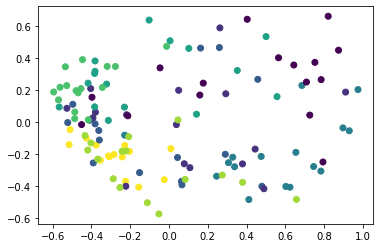

In [ ]:
# embeddings on never seen speakers after softmax training
samps = softmx_embd_model_best.predict(vsample_stuff['feats'])
samps = tf.nn.l2_normalize(samps, axis=1)
# X = sklearn.manifold.TSNE(n_components=2).fit_transform(samps)
X = sklearn.decomposition.PCA(2).fit_transform(samps)
plt.scatter(X[:,0], X[:,1], c=vsample_stuff['labels']) 

In [ ]:
del softmax_training_model

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 706kB 14.5MB/s 


In [ ]:
# for triplet training
input_feats  = tf.keras.layers.Input(shape=embd_model.input_shape[1:])
embeddings = softmx_embd_model_best(input_feats)
embeddings = tf.nn.l2_normalize(embeddings, axis=1)
triplet_training_model = tf.keras.Model(input_feats, embeddings)
optimizer = K.optimizers.RMSprop(learning_rate=1e-7)
triplet_training_model.compile(optimizer, tfa.losses.TripletSemiHardLoss())

In [ ]:
# run this cell for reloading a previous model
try:
    triplet_training_model = K.models.load_model("ckpt/triplet_training_model.model")
    triplet_training_model.save("ckpt/copy_of_triplet_training_model.model")
    print("last lr:", triplet_training_model.optimizer.learning_rate.numpy())
except:
    print("reload failed") 

INFO:tensorflow:Assets written to: ckpt/copy_of_triplet_training_model.model/assets


INFO:tensorflow:Assets written to: ckpt/copy_of_triplet_training_model.model/assets


last lr: 1e-07


In [ ]:
# change learning rate if required
triplet_training_model.optimizer.learning_rate

In [ ]:
# for triplet pretraining
tf_train_dataset = train_datagen.get_usual_tf_dataset()
tf_val_dataset = val_datagen.get_usual_tf_dataset()

hist = triplet_training_model.fit(tf_train_dataset, epochs=25,
                validation_data= tf_val_dataset,
                steps_per_epoch=train_stpe,
                validation_steps=5,
                callbacks=[
                K.callbacks.ReduceLROnPlateau(monitor='loss'),
                K.callbacks.ModelCheckpoint("ckpt/triplet_training_model.model", monitor="val_loss", verbose=0, save_best_only=True)
                ])

Epoch 1/25
20/20 [==============================] - 43s 2s/step - loss: 0.9860 - val_loss: 0.9915


In [ ]:
# load the best checkpointed model
triplet_embd_model_best = K.models.load_model("ckpt/triplet_training_model.model").get_layer("embd_model")
triplet_embd_model_best.save("ckpt/triplet_embd_model_best.model")
triplet_embd_model_best.save_weights("triplet_embd_model_best.h5")

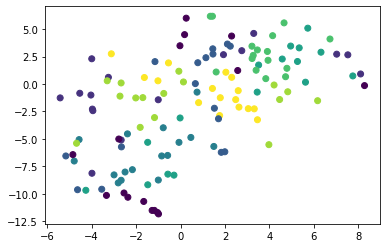

In [ ]:
# embeddings on never seen and unseen segments of seen speakers after triplet training
fig = plt.figure(figsize=(10,5))
ax1,ax2 = fig.subplots(1, 2)

vsamps = triplet_embd_model_best.predict(vsample_stuff['feats'])
vsamps = tf.nn.l2_normalize(samps, axis=1)
vX = sklearn.manifold.TSNE(n_components=2).fit_transform(vsamps)
# vX = sklearn.decomposition.PCA(2).fit_transform(vsamps)
ax1.scatter(vX[:,0], vX[:,1], c=vsample_stuff['labels']) 
ax1.set(title="val: unseen speakers")

dsamps = triplet_embd_model_best.predict(dsample_stuff['feats'])
dsamps = tf.nn.l2_normalize(dsamps, axis=1)
dX = sklearn.manifold.TSNE(n_components=2).fit_transform(dsamps)
# dX = sklearn.decomposition.PCA(2).fit_transform(dsamps)
ax2.scatter(dX[:,0], dX[:,1], c=dsample_stuff['labels']) 
ax2.set(title="dev: unseen segments of seen speakers")

plt.tight_layout()

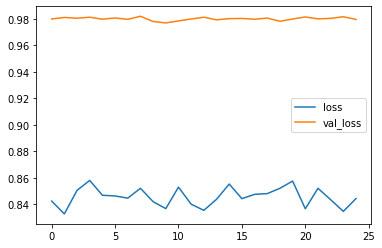

In [ ]:
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.legend()

In [ ]:
del triplet_training_model